In [1]:
!pip install transformers

     |████████████████████████████████| 2.1MB 18.1MB/s 
     |████████████████████████████████| 901kB 51.8MB/s 
     |████████████████████████████████| 3.3MB 53.1MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import TFGPT2LMHeadModel, PreTrainedTokenizerFast
import tensorflow as tf
import tqdm
from nltk.translate.bleu_score import SmoothingFunction, modified_precision, sentence_bleu

# 2. 전처리

In [3]:
!wget -c https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv

--2021-04-28 11:22:44--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv [following]
--2021-04-28 11:22:44--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv’

ChatbotData .csv    100%[===================>] 868.99K  --.-KB/s    in 0.02s   

2021-04-28 11:22:45 (54.6 MB/s) - ‘ChatbotData .csv’ saved [889842/889842]



In [4]:
df2=pd.read_csv('ChatbotData .csv')

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
df=pd.read_excel('/gdrive/My Drive/웰니스_대화_스크립트_데이터셋.xlsx')

In [7]:
df.columns=['label','Q','A']

In [8]:
chat=pd.concat([df2,df],axis=0).reset_index(drop=True)
chat.dropna(inplace=True)
chat=chat.reset_index(drop=True)

#3. 전처리

In [9]:
chat.Q.value_counts() #데이터의 Q열에 중복된 질문들이 있음

외로워              4
너무 힘들다           3
올해 왜 이러지         3
사랑을 했다           3
마음이 울적해          2
                ..
봄이 왔어            1
그녀를 떠나보내야 하나?    1
끈어져 버린 인연의 고리    1
나약한 생각           1
집 사고 싶어          1
Name: Q, Length: 12696, dtype: int64

In [10]:
chat.A.value_counts() #데이터의 각기 다른 질문에 대한 중복된 대답이 있음

맛있게 드세요.                                     22
제가 있잖아요.                                     17
조심하세요.                                       14
감기 조심하세요.                                    14
직접 물어보세요.                                    12
                                             ..
본인의 생각에 귀를 기울여봐요. 이미 답은 정해져 있을지도 몰라요.         1
답답할 거라 생각해요.                                  1
미안해하지 않아도 돼요. 새사람에게 충실하세요.                    1
스트레스 받는 일이 있으신가요? 괜찮으시다면 저한테 털어 놓으셔도 좋아요.     1
유유상종이네요.                                      1
Name: A, Length: 8801, dtype: int64

In [11]:
chat[chat.Q=='외로워'] #같은질문에도 다른 대답들이 들어있음

,Q,A,label
3456,외로워,친구를 사귀어 보세요.,0
3457,외로워,혼자가 아니에요.,0
7261,외로워,제가 곁에 있을게요.,1
7262,외로워,혼자가 아니에요.,1


- 그중에서 중복된 대답의 갯수가 많은 것으로 판단되어 중복된 대답을 가진 질문 중 질문의 내용이 비슷한 행을 제거하기로 하였다.

In [12]:
l=pd.DataFrame(df2.A.value_counts())[pd.DataFrame(df2.A.value_counts()).loc[:,'A']>2].index.tolist()

In [13]:
sameanswer=chat[chat['A'].isin(l)]['Q'].tolist()

비슷한 질문을 파악하기 위해 bleu지표를 사용하여 bleu가 0.85가 넘는 질문은 비슷한 내용의 질문이라고 판단하고 제거한다

In [14]:
bl=[]
for i, j in tqdm.tqdm_notebook(enumerate(sameanswer)):
  
  if i<2060:
    for k in range(i+1,i+10):
      bleu=sentence_bleu(j, sameanswer[k])
      if bleu>0.85: 
        bl.append(j)
  else:
    for k in range(i,2069-i):
      bleu=sentence_bleu(j, sameanswer[k])
      if bleu>0.85:
        bl.append(j) 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [15]:
chat=chat.drop(index=chat.Q[chat.Q.isin(list(set(bl)))].index)

In [47]:
#test셋 형성
train=chat[:-26]
test=chat[-26:]

In [17]:
import random
random.seed(30)

In [18]:
valid_num=random.sample(range(len(train)),3684)

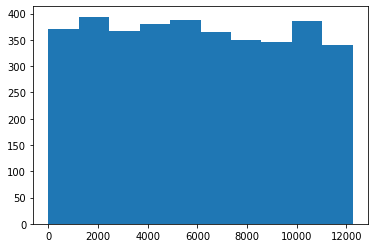

In [19]:
plt.hist(valid_num) #어느정도 고르게 분포되어있다
plt.show()

In [20]:
#validation set 생성
valid_chat=trainiloc[valid_num,:]
train_chat=train.iloc[~train.index.isin(valid_num),:]

In [22]:
model = TFGPT2LMHeadModel.from_pretrained("/gdrive/My Drive/kogpt2/taeminlee", from_pt=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained("/gdrive/My Drive/kogpt2/taeminlee")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.6.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'lm_head.weight', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.5.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [23]:
traindata = []
for row in train_chat.itertuples():
    print(row)
    tokens = tokenizer.encode(f'<s>Q: {row.Q} A: {row.A}</s>') #Q:question, A:answer
    tokens = [t for t in tokens if t < tokenizer.vocab_size]
    traindata.append(tokens)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Pandas(Index=5822, Q='날씨가 좋아서 좋긴한데 또 싫네', A='복잡하네요.', label=1)
Pandas(Index=5823, Q='날씨가 차서 그런지', A='마음도 추운가요.', label=1)
Pandas(Index=5824, Q='날씨가 참 안도와주네', A='그래도 웃어 보아요.', label=1)
Pandas(Index=5825, Q='날이 꿀꾸리', A='그래도 웃어 보아요.', label=1)
Pandas(Index=5826, Q='날이 많이 추운데.', A='감기 조심하세요.', label=1)
Pandas(Index=5827, Q='남긴게 없이 줬다고 믿어.', A='좋은 마음이네요.', label=1)
Pandas(Index=5828, Q='남동생한테 자꾸 화내게 되네', A='화를 참는 연습을 해보세요.', label=1)
Pandas(Index=5830, Q='남은건 너의 빈자리', A='빈 자리도 채워질 거예요.', label=1)
Pandas(Index=5831, Q='남자 못믿겠어.', A='믿게 할 남자가 생길 거예요.', label=1)
Pandas(Index=5832, Q='남자가 못잊는 여자', A='당신.', label=1)
Pandas(Index=5833, Q='남자들에게 말 못하는 여자들의 이별 세가지.', A='세 가지 이상이죠.', label=1)
Pandas(Index=5836, Q='남자분들 질문이', A='직접 물어보세요.', label=1)
Pandas(Index=5837, Q='남자분들께 궁금 해.', A='직접 물어보세요.', label=1)
Pandas(Index=5838, Q='남자의심리 모르겠어', A='직접 물어보세요.', label=1)
Pandas(Index=5839, Q='남자인지 여자인지 알려줘', A='아직 모르겠어요. 인공지능에 성별을 만드는 사람이 되어 주세요', label=1)
Pandas(Index=

In [24]:
validdata = []
for row in valid_chat.itertuples():
    print(row)
    tokens = tokenizer.encode(f'<s>Q: {row.Q} A: {row.A}</s>') #Q:question, A:answer
    tokens = [t for t in tokens if t < tokenizer.vocab_size]
    validdata.append(tokens)

Pandas(Index=9357, Q='남자친구가 질투를 안해', A='보살인가봅니다.', label=2)
Pandas(Index=5059, Q='핸드폰 꺼지기 직전', A='충전하고 만나요.', label=0)
Pandas(Index=10565, Q='여자친구가 감정없이 카톡 답장해', A='상처받고 있다고 말해보세요.', label=2)
Pandas(Index=517, Q='나 어때?', A='괜찮은 사람이에요.', label=0)
Pandas(Index=10747, Q='연애하는 것처럼 결혼 가능해?', A='배려하고 존중하면서 사랑하면 가능할 거예요.', label=2)
Pandas(Index=11277, Q='좋아하면서도 너무 싫은 감정 뭘까요.', A='좋아하는 만큼 지쳐가는 마음 아닐까요.', label=2)
Pandas(Index=3681, Q='이렇게 대학 가야하나', A='행복은 마음 가짐에 있어요.', label=0)
Pandas(Index=4501, Q='최고다 행복해', A='우리가 사랑받고 있음을 확신하는 것입니다.', label=0)
Pandas(Index=832, Q='내가 너무 생각없이 말했어', A='생각하고 말하세요.', label=0)
Pandas(Index=6893, Q='아픔은 덜해지는것 같은데 미련은 더욱 많아지네', A='미련없는 사랑은 없나봐요.', label=1)
Pandas(Index=6543, Q='비가 오니.울컥하네', A='그러게요. 비가 추적추적 내려요.', label=1)
Pandas(Index=11078, Q='좋아하는 사람 때문에 공부를 못하겠어.', A='충분히 그럴 수 있어요.', label=2)
Pandas(Index=2335, Q='상 받으면 좋겠지?', A='아무래도 뿌듯할 거예요.', label=0)
Pandas(Index=1411, Q='또 어떻게 버티지?', A='내일은 나을 거예요.', label=0)
Pandas(Index=7987, Q='전남친이 톡 차단했더라구', A='이별에 도

# 4. 모형 및 데이터 입력 방식

In [26]:
def data_generator():
  for datum in traindata:
    yield datum

def validdata_generator():
  for datum in validdata:
    yield datum

In [27]:
train_dataset=tf.data.Dataset.from_generator(data_generator, output_types=tf.int32)
train_dataset=train_dataset.padded_batch(32,padded_shapes=(None, ),padding_values=tokenizer.pad_token_id )#32개씩 묶어서 배치로 만들어라
train_batch=next(iter(train_dataset))

for train_batch in train_dataset:
    print(train_batch)
    break

tf.Tensor(
[[    0  4322 47820   141 47650 47514 47471  2211 47593  2999  5314   450
  47820  1791 47459 15515   548 48159 47440     1     3     3     3     3
      3     3     3     3]
 [    0  4322 47820   141 47650 47514 47471  1057  2211 47593  2999  5314
    450 47820  1791 47459 15515   548 48159 47440     1     3     3     3
      3     3     3     3]
 [    0  4322 47820   753  9003   415 20572   450 47820   637 10855  7776
  48071 47628 47445 48159 47440     1     3     3     3     3     3     3
      3     3     3     3]
 [    0  4322 47820 24138  1506 27165 47816 47487   450 47820   768  3278
   3641   348  1438   560 10831 47440     1     3     3     3     3     3
      3     3     3     3]
 [    0  4322 47820 24138  1506 12294   450 47820   768  3278  3641   348
   1438   560 10831 47440     1     3     3     3     3     3     3     3
      3     3     3     3]
 [    0  4322 47820  3029   782 48359 34538   241   134   501  2922   455
    133   450 47820  3351 14655   171  4

In [28]:
valid_dataset=tf.data.Dataset.from_generator(validdata_generator, output_types=tf.int32)
valid_dataset=valid_dataset.padded_batch(32,padded_shapes=(None, ),padding_values=tokenizer.pad_token_id )#32개씩 묶어서 배치로 만들어라
valid_batch=next(iter(valid_dataset))

# 5. 미세조정

In [42]:
total = len(traindata)//32 #batchsize=32
total_val = len(validdata)//32+1 #batchsize=32
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-6, epsilon = 1e-08)
history1=[]
history2=[]

for i in range(10): #epoch:10
  for batch in tqdm.tqdm_notebook(train_dataset,total=total):
    with tf.GradientTape() as tape:
      result=model(train_batch, labels=train_batch)
      loss = result[0] #손실 기록
      mean_loss=tf.reduce_mean(loss) #손실의 평균을 구함 (해당 배치의)
    
    grads=tape.gradient(mean_loss,model.trainable_variables) #훈련시킬수 있는 변수들: 파라미터들의 변수를 업데이트 해라
    opt.apply_gradients(zip(grads,model.trainable_variables))
  print(mean_loss)
  history1.append(mean_loss)

  for batch in tqdm.tqdm_notebook(valid_dataset,total=total_val):
    with tf.GradientTape() as tape:
      result=model(valid_batch, labels=valid_batch,training=False) #training=False 해애함
      loss = result[0] #손실 기록
      mean_val_loss=tf.reduce_mean(loss) #손실의 평균을 구함 (해당 배치의)

  print(mean_val_loss)
  history2.append(mean_val_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



tf.Tensor(3.7124858, shape=(), dtype=float32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



tf.Tensor(4.270462, shape=(), dtype=float32)



tf.Tensor(2.7839327, shape=(), dtype=float32)



tf.Tensor(4.1145124, shape=(), dtype=float32)



tf.Tensor(1.8574048, shape=(), dtype=float32)



tf.Tensor(4.664675, shape=(), dtype=float32)



tf.Tensor(1.5072877, shape=(), dtype=float32)



tf.Tensor(4.686908, shape=(), dtype=float32)



tf.Tensor(1.2872055, shape=(), dtype=float32)



tf.Tensor(4.438646, shape=(), dtype=float32)



tf.Tensor(1.0476369, shape=(), dtype=float32)



tf.Tensor(4.187831, shape=(), dtype=float32)



tf.Tensor(0.7965165, shape=(), dtype=float32)



tf.Tensor(4.022141, shape=(), dtype=float32)



tf.Tensor(0.4717345, shape=(), dtype=float32)



tf.Tensor(3.8061025, shape=(), dtype=float32)



tf.Tensor(0.18676601, shape=(), dtype=float32)



tf.Tensor(3.6122205, shape=(), dtype=float32)



tf.Tensor(0.13691173, shape=(), dtype=float32)



tf.Tensor(3.6221967, shape=(), dtype=float32)


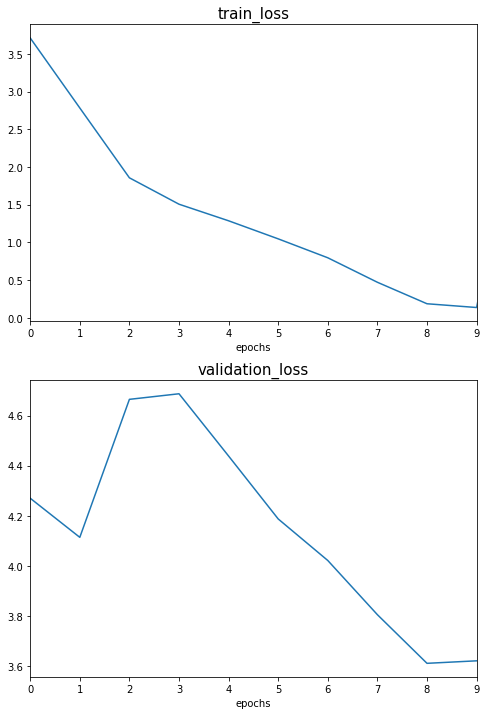

In [75]:
fig, ax = plt.subplots(2,1,figsize=(8,12))

ax[0].plot(history1)
ax[0].set_title('train_loss',fontsize=15)
ax[0].set_xlim([0,9])
ax[0].set_xlabel('epochs')

ax[1].plot(history2)
ax[1].set_title('validation_loss',fontsize=15)
ax[1].set_xlim([0,9])
ax[1].set_xlabel('epochs')
plt.show()

#9번 에포크가 Val_loss를 줄여준다.

In [ ]:
#에포크 확인 후 재학습

In [51]:
data = []
for row in train.itertuples():
    print(row)
    tokens = tokenizer.encode(f'<s>Q: {row.Q} A: {row.A}</s>') #Q:question, A:answer
    tokens = [t for t in tokens if t < tokenizer.vocab_size]
    data.append(tokens)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Pandas(Index=7673, Q='이제 놓을수 있을것 같아', A='충분한 마음의 정리를 했나봅니다.', label=1)
Pandas(Index=7674, Q='이제 누구 만나는 것도 지치네', A='새로운 만남은 언제나 어려운 것 같아요.', label=1)
Pandas(Index=7675, Q='이제 더이상 남자친구로 안느껴진다는 그녀', A='익숙함이라는 타성에 젖은 건 아닐까 생각해봅니다.', label=1)
Pandas(Index=7676, Q='이제 때론 괜찮기도 해', A='그렇게 익숙해져 가나봐요.', label=1)
Pandas(Index=7677, Q='이제 마음 정리도 된 거 같은데', A='그럼 새로운 인연을 기다려보세요.', label=1)
Pandas(Index=7679, Q='이제 막 이별을.', A='혼자만의 시간이 필요하겠어요.', label=1)
Pandas(Index=7680, Q='이제 모든게 퍼즐처럼 맞춰지네', A='곱씹어도 아픈 기억인 걸요.', label=1)
Pandas(Index=7681, Q='이제 반년이란 시간이 흘렀는데', A='좀 나아졌길 기대합니다.', label=1)
Pandas(Index=7682, Q='이제 밥도 잘 먹구 술은 안마시면 되겠는데', A='복잡한 머리 속이 문제네요.', label=1)
Pandas(Index=7683, Q='이제 보내주려 합니다.', A='많이 고민 했을거라 생각해요.', label=1)
Pandas(Index=7684, Q='이제 보름 다되어가네', A='생각 보다 잘 버텼어요.', label=1)
Pandas(Index=7685, Q='이제 사진 지운 이유는?', A='마음의 준비가 필요했을지도 몰라요.', label=1)
Pandas(Index=7686, Q='이제 세달째', A='짧지 않은 시간이지요.', label=1)
Pandas(Index=7687, Q='이제 숨 좀 쉬나', A='충분히

In [52]:
def data_generator():
  for datum in data:
    yield datum

In [53]:
dataset=tf.data.Dataset.from_generator(data_generator, output_types=tf.int32)
dataset=dataset.padded_batch(32,padded_shapes=(None, ),padding_values=tokenizer.pad_token_id )#32개씩 묶어서 배치로 만들어라
batch=next(iter(dataset))

In [54]:
model = TFGPT2LMHeadModel.from_pretrained("/gdrive/My Drive/kogpt2/taeminlee", from_pt=True)
tokenizer = PreTrainedTokenizerFast.from_pretrained("/gdrive/My Drive/kogpt2/taeminlee")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2LMHeadModel: ['transformer.h.6.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.10.attn.masked_bias', 'lm_head.weight', 'transformer.h.4.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias', 'transformer.h.5.attn.masked_bias']
- This IS expected if you are initializing TFGPT2LMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2LMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassifica

In [57]:
total = len(data)//32
opt = tf.keras.optimizers.RMSprop(learning_rate=1e-6, epsilon = 1e-08)

for i in range(9): #epoch:10
  for batch in tqdm.tqdm_notebook(dataset,total=total):
    with tf.GradientTape() as tape:
      result=model(batch, labels=batch)
      loss = result[0] #손실 기록
      mean_loss=tf.reduce_mean(loss) #손실의 평균을 구함 (해당 배치의)
    
    grads=tape.gradient(mean_loss,model.trainable_variables) #훈련시킬수 있는 변수들: 파라미터들의 변수를 업데이트 해라
    opt.apply_gradients(zip(grads,model.trainable_variables))
  print(mean_loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



tf.Tensor(3.4454978, shape=(), dtype=float32)



tf.Tensor(3.3148923, shape=(), dtype=float32)



tf.Tensor(3.208477, shape=(), dtype=float32)



tf.Tensor(3.1047378, shape=(), dtype=float32)



tf.Tensor(2.9770052, shape=(), dtype=float32)



tf.Tensor(2.8037333, shape=(), dtype=float32)



tf.Tensor(2.6648836, shape=(), dtype=float32)



tf.Tensor(2.5117407, shape=(), dtype=float32)



tf.Tensor(2.4681249, shape=(), dtype=float32)


In [148]:
model.save_pretrained("/gdrive/My Drive/kogpt2/my_chat_model2")

In [28]:
model=TFGPT2LMHeadModel.from_pretrained("/gdrive/My Drive/kogpt2/my_chat_model2")

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /gdrive/My Drive/kogpt2/my_chat_model2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


# 6. 평가



In [90]:
bleu_hist=[]
for text,answer in zip(test_chat.Q,test_chat.A):
  sent = f'<s>Q: {text} A:'
  input_ids = tokenizer.encode(sent, return_tensors='tf')
  output = model.generate(input_ids, max_length=50, do_sample=True,    
  top_k=50, # 확률 순위가 50위 밖인 토큰은 샘플링에서 제외
  top_p=0.95, # 누적 확률이 95%인 후보집합에서만 생성
  num_return_sequences=3, #3개의 결과를 디코딩해낸다 -> 최고의 bleu결과를 뽑아내는애를 도출
  early_stopping=True, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id)

  a=answer
  b=tokenizer.decode(output[0]).split('A: ')[1].split('</s>')[0]

  bleu=sentence_bleu(a, b,smoothing_function=SmoothingFunction().method4)
  bleu_hist.append(bleu)
  print('BLEU:',bleu )
print(np.mean(bleu_hist))

BLEU: 0.23640501160890146
BLEU: 0.2802636449867835
BLEU: 0.3001539509824141
BLEU: 0.24412112840905476
BLEU: 0.29044557694430123
BLEU: 0.2879903284693138
BLEU: 0.2925224248656244
BLEU: 0.28363965162389637
BLEU: 0.3231089111844942
BLEU: 0.29044557694430123
BLEU: 0.272364436623922
BLEU: 0.276619911786786
BLEU: 0.2744535278544658
BLEU: 0.26824982050388396
BLEU: 0.23215428075437497
BLEU: 0.22557031245416842
BLEU: 0.24050489849859652
BLEU: 0.26850597638020296
BLEU: 0.2539372741287818
BLEU: 0.29578976092515924
BLEU: 0.28363965162389637
BLEU: 0.2616251520741159
BLEU: 0.28579596974917193
BLEU: 0.2659499096001465
BLEU: 0.27558280889605025
BLEU: 0.25153238730449584
0.2715912417375886


In [61]:
text='나 우울해'
sent = f'<s>Q: {text} A:'
input_ids = tokenizer.encode(sent, return_tensors='tf')
output = model.generate(input_ids, max_length=50, do_sample=True,    
top_k=50, # 확률 순위가 50위 밖인 토큰은 샘플링에서 제외
top_p=0.95, # 누적 확률이 95%인 후보집합에서만 생성
num_return_sequences=3, #3개의 결과를 디코딩해낸다 -> 최고의 bleu결과를 뽑아내는애를 도출
early_stopping=True, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id)
tokenizer.decode(output[0]).split('A:')[1].split('</s>')[0]

' 이제 우울한 일상은 내려갔으면 좋겠어요.'

In [96]:
text='아무도 내편이 없어'
sent = f'<s>Q: {text} A:'
input_ids = tokenizer.encode(sent, return_tensors='tf')
output = model.generate(input_ids, max_length=50, do_sample=True,    
top_k=50, # 확률 순위가 50위 밖인 토큰은 샘플링에서 제외
top_p=0.95, # 누적 확률이 95%인 후보집합에서만 생성
num_return_sequences=3, #3개의 결과를 디코딩해낸다 -> 최고의 bleu결과를 뽑아내는애를 도출
early_stopping=True, eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id)
tokenizer.decode(output[0]).split('A:')[1].split('</s>')[0]

' 항상 내편이 있을 거에요.'